In [12]:
#############################################
#Metadata                                   #
#############################################


import xarray as xr

# Open the wrfout file
file = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"
ds = xr.open_dataset(file)

# Variables of interest
vars_of_interest = [
    "T2",     # 2-m air temperature
    "U10",    # 10-m U wind
    "V10",    # 10-m V wind
    "EMISS",  # Net longwave upward flux at surface (check name: may be "RLWTOA" or "GLW")
    "GLW",
    "TSK",    # Skin temperature
    "HFX",    # Surface sensible heat flux
    "T",      # Perturbation potential temperature    
    "PH",
    "PHB",
    "HGT",
    "XLAT",
    "XLONG",
    "P",
    "QVAPOR",
    "Rh",
    "U", "V", "W",  # 3D wind components
    "m11", "m22", "m33",   # Mass variables (maybe you meant m11, m22, m33 from metric terms)
]

for var in vars_of_interest:
    if var in ds.variables:
        print(f"\n===== {var} =====")
        print(ds[var])
    else:
        print(f"\n--- {var} not found in file ---")



===== T2 =====
<xarray.DataArray 'T2' (Time: 217, south_north: 426, west_east: 426)> Size: 158MB
[39380292 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 158MB ...
    XLONG    (Time, south_north, west_east) float32 158MB ...
    XTIME    (Time) datetime64[ns] 2kB ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   TEMP at 2 M
    units:         K
    stagger:       
    cell_methods:  Time: mean

===== U10 =====
<xarray.DataArray 'U10' (Time: 217, south_north: 426, west_east: 426)> Size: 158MB
[39380292 values with dtype=float32]
Coordinates:
    XLAT     (Time, south_north, west_east) float32 158MB ...
    XLONG    (Time, south_north, west_east) float32 158MB ...
    XTIME    (Time) datetime64[ns] 2kB ...
Dimensions without coordinates: Time, south_north, west_east
Attributes:
    FieldType:     104
    MemoryOrder:   XY 
    description:   U at 10 M

In [1]:
#############################################
#Data Extraction                            #
#############################################


import xarray as xr
import numpy as np

# Open the wrfout file
file = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"
ds = xr.open_dataset(file)

# Target location
target_lat = 28.5658
target_lon = 77.0943

# Variables of interest
vars_of_interest = [
    "T2", "U10", "V10", "EMISS", "GLW", "TSK", "HFX", "T",
    "Rh", "PH", "PHB", "HGT", "XLAT", "XLONG", "P", "QVAPOR", "QCLOUD",
    "U", "V", "W", "m11", "m22", "m33"
]

# 1️⃣ Find nearest grid point
lat = ds["XLAT"].isel(Time=0)
lon = ds["XLONG"].isel(Time=0)
dist = np.sqrt((lat - target_lat)**2 + (lon - target_lon)**2)
j, i = np.unravel_index(dist.argmin(), dist.shape)

print(f"Nearest grid point: lat={float(lat[j,i].values):.4f}, lon={float(lon[j,i].values):.4f}, indices=({j},{i})")

# 2️⃣ Extract variables at that point
extracted = {}
for var in vars_of_interest:
    if var in ds.variables:
        try:
            if "south_north" in ds[var].dims and "west_east" in ds[var].dims:
                extracted[var] = ds[var].isel(south_north=j, west_east=i)
            elif "y" in ds[var].dims and "x" in ds[var].dims:
                extracted[var] = ds[var].isel(y=j, x=i)
            else:
                extracted[var] = ds[var]
            print(f"✅ Extracted {var}")
        except Exception as e:
            print(f"⚠️ Could not extract {var}: {e}")
    else:
        print(f"--- {var} not found in file ---")

# 3️⃣ Combine into dataset
point_ds = xr.Dataset(extracted)

# 4️⃣ Save to NetCDF
output_file = "processed_7th_Jan_2023_data.nc"
point_ds.to_netcdf(output_file)

print(f"\n🎉 Saved extracted dataset to {output_file}")


/home/users/choudhury/Conda/envs/wrf_env/lib/python3.11/site-packages/pyproj/network.py:59: UserWarning: pyproj unable to set PROJ database path.
  _set_context_ca_bundle_path(ca_bundle_path)


Nearest grid point: lat=28.5654, lon=77.0938, indices=(229,196)
✅ Extracted T2
✅ Extracted U10
✅ Extracted V10
✅ Extracted EMISS
✅ Extracted GLW
✅ Extracted TSK
✅ Extracted HFX
✅ Extracted T
--- Rh not found in file ---
✅ Extracted PH
✅ Extracted PHB
✅ Extracted HGT
✅ Extracted XLAT
✅ Extracted XLONG
✅ Extracted P
✅ Extracted QVAPOR
✅ Extracted QCLOUD
✅ Extracted U
✅ Extracted V
✅ Extracted W
✅ Extracted m11
✅ Extracted m22
✅ Extracted m33

🎉 Saved extracted dataset to processed_7th_Jan_2023_data.nc


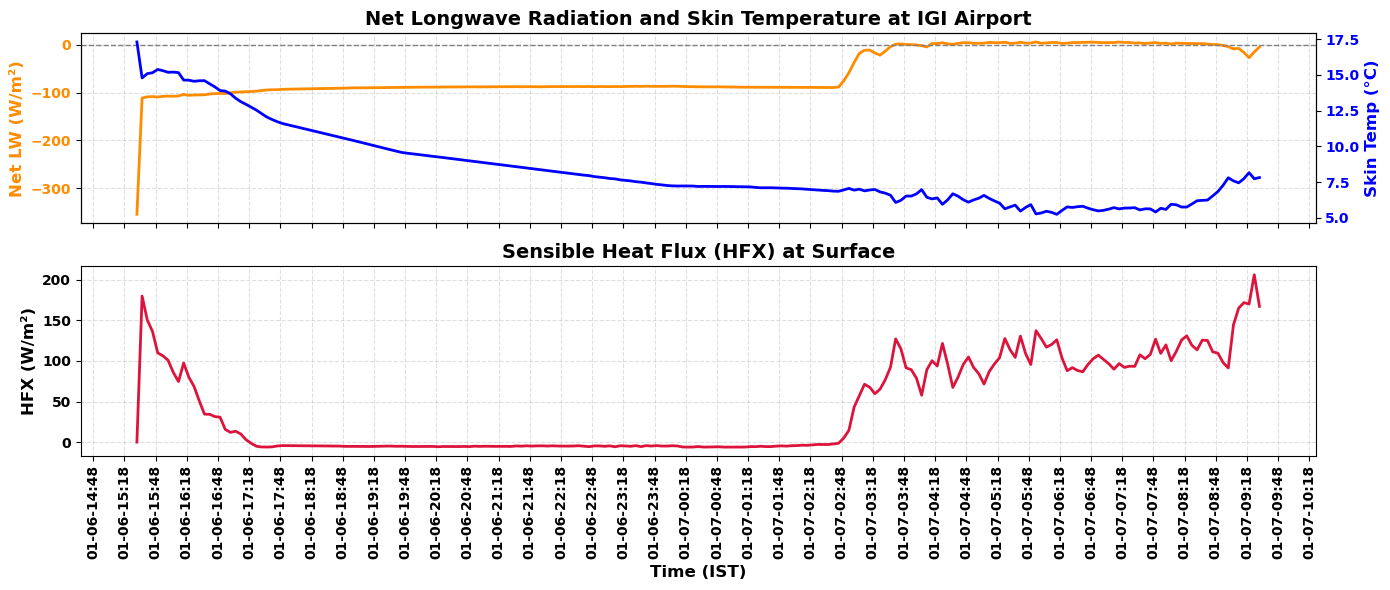

In [4]:
#############################################
#Net Longwave Radiation and Skin Temperature#
#Sensible Heat FLux                         #
#############################################
#__[Figure6]__#

import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Constants
sigma = 5.67e-8  # Stefan-Boltzmann constant in W/m²·K⁴

# File and location
file_path = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"
target_lat = 28.5658
target_lon = 77.1035

# Open dataset
ds = xr.open_dataset(file_path)

# Find closest grid point
def find_nearest(lat, lon, lats, lons):
    dist = (lats - lat)**2 + (lons - lon)**2
    return np.unravel_index(dist.argmin(), dist.shape)

y_idx, x_idx = find_nearest(target_lat, target_lon, ds.XLAT[0], ds.XLONG[0])
times_ist = pd.to_datetime(ds.XTIME.values) + pd.Timedelta(hours=5, minutes=30)

# Extract required data
tsk = ds['TSK'][:, y_idx, x_idx].values  # Skin temperature (K)
emiss = ds['EMISS'][:, y_idx, x_idx].values
glw = ds['GLW'][:, y_idx, x_idx].values
hfx = ds['HFX'][:, y_idx, x_idx].values  # Sensible heat flux (W/m²)

# Compute derived quantities
lwup = emiss * sigma * (tsk ** 4)  # Upward longwave radiation
net_lw = glw - lwup                # Net longwave radiation
tsk_C = tsk - 273.15               # Skin temperature in °C

# Set global bold font
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

# Create subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 6), sharex=True)
plt.subplots_adjust(hspace=0.4)

# --- Plot 1: Net LW Radiation and Skin Temperature ---
ax1.plot(times_ist, net_lw, color='darkorange', label='Net LW (GLW - LWUP)', linewidth=2)
ax1.set_ylabel('Net LW (W/m²)', color='darkorange', fontsize=12)
ax1.tick_params(axis='y', labelcolor='darkorange')
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)

# Twin y-axis for skin temperature
ax1b = ax1.twinx()
ax1b.plot(times_ist, tsk_C, color='blue', label='Skin Temp (°C)', linewidth=2)
ax1b.set_ylabel('Skin Temp (°C)', color='blue', fontsize=12)
ax1b.tick_params(axis='y', labelcolor='blue')

# Title and grid
ax1.set_title('Net Longwave Radiation and Skin Temperature at IGI Airport', fontsize=14, fontweight='bold')
ax1.grid(True, linestyle='--', alpha=0.4)

# --- Plot 2: Sensible Heat Flux ---
ax2.plot(times_ist, hfx, color='crimson', label='Sensible Heat Flux (HFX)', linewidth=2)
ax2.set_title('Sensible Heat Flux (HFX) at Surface', fontsize=14, fontweight='bold')
ax2.set_ylabel('HFX (W/m²)', fontsize=12, fontweight='bold')
ax2.set_xlabel('Time (IST)', fontsize=12, fontweight='bold')
ax2.grid(True, linestyle='--', alpha=0.4)

# Tick formatting: every 30 minutes
locator = mdates.MinuteLocator(interval=30)
formatter = mdates.DateFormatter("%m-%d-%H:%M")
ax2.xaxis.set_major_locator(locator)
ax2.xaxis.set_major_formatter(formatter)
plt.setp(ax2.get_xticklabels(), rotation=90, fontweight='bold')

# Tick weight for y-axis
for ax in [ax1, ax1b, ax2]:
    for label in ax.get_yticklabels():
        label.set_fontweight('bold')

fig.tight_layout()
plt.show()

ds.close()


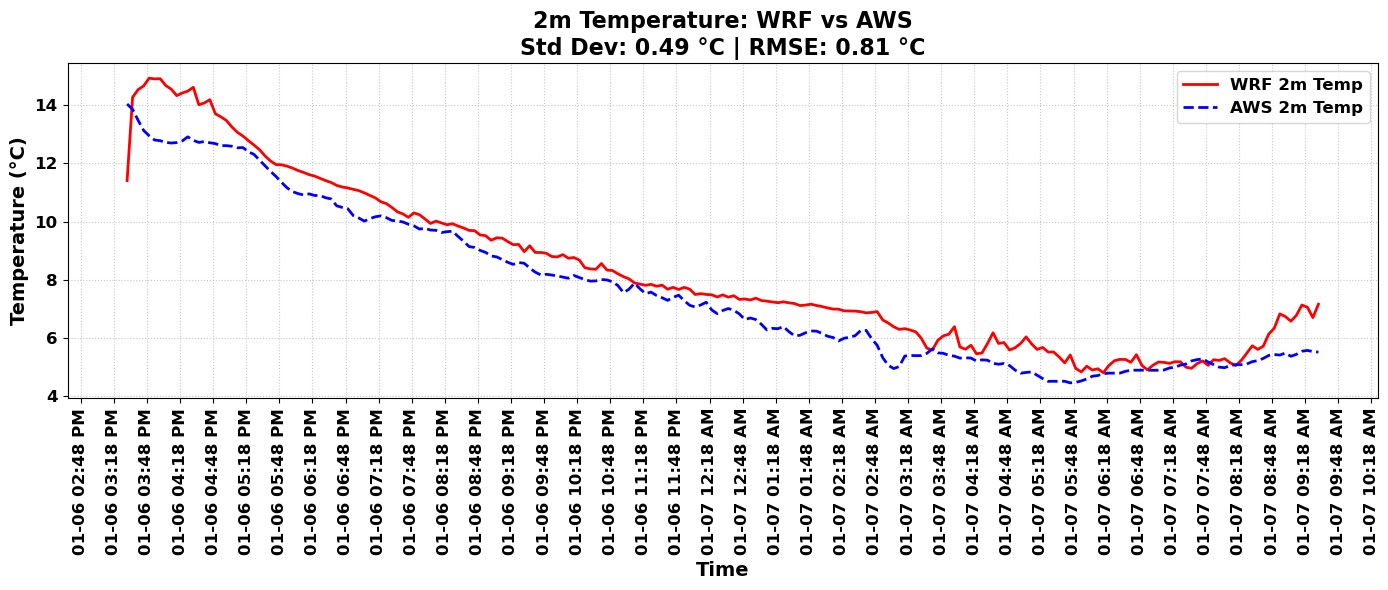

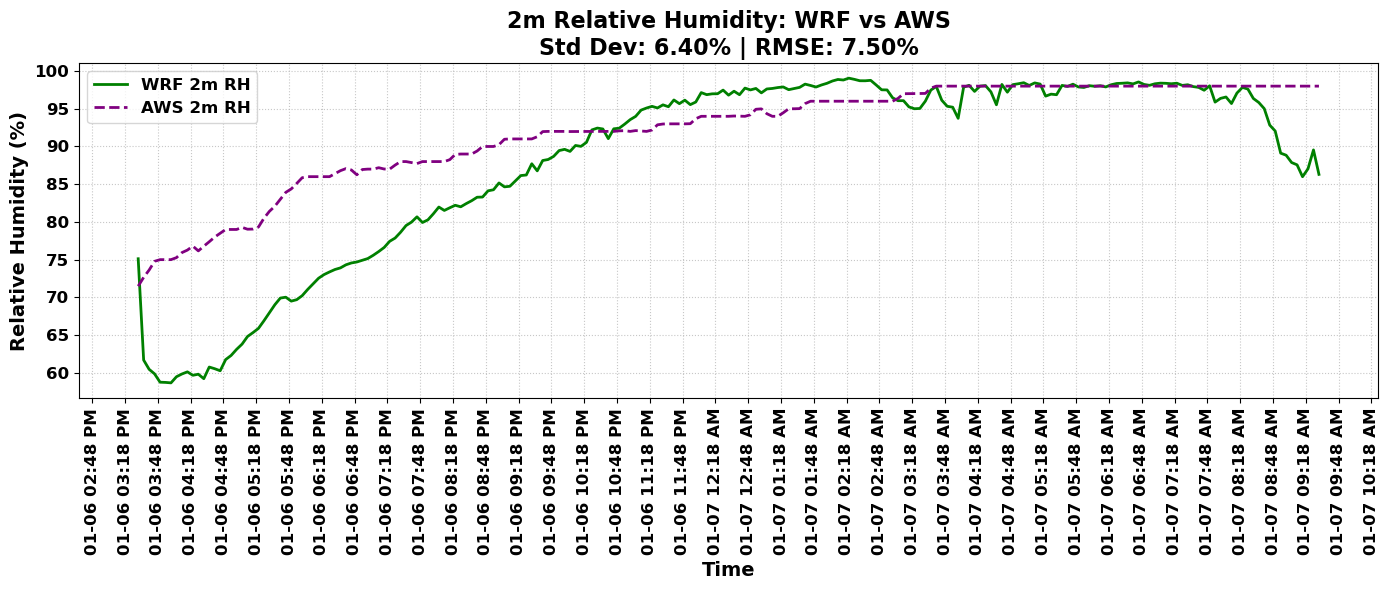

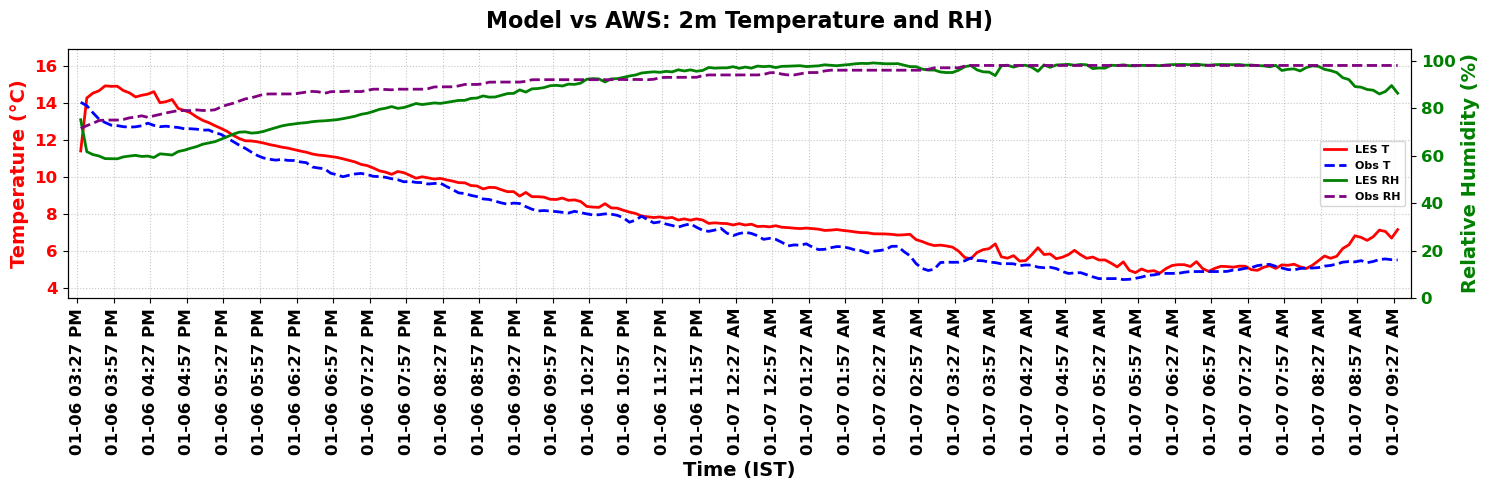

In [6]:
#############################################
#Model vs AWS temperature and RH            #
#############################################
#__[Figure5a]__#

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from netCDF4 import Dataset
from wrf import getvar, latlon_coords, extract_times, ALL_TIMES, to_np

# --- User-defined latitude and longitude ---
target_lat = 28.56697932277561
target_lon = 77.09886440400123

# --- WRF Data Processing ---
wrf_file_path = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"

wrf_temp = wrf_rh = time_np_wrf = None

try:
    wrf_data_nc = Dataset(wrf_file_path, "r")
    t2 = getvar(wrf_data_nc, "T2", timeidx=ALL_TIMES) - 273.15
    rh2 = getvar(wrf_data_nc, "rh2", timeidx=ALL_TIMES)
    lats, lons = latlon_coords(t2)

    dist_sq = (lats - target_lat)**2 + (lons - target_lon)**2
    min_idx = np.unravel_index(np.argmin(to_np(dist_sq)), dist_sq.shape)

    wrf_temp = to_np(t2[:, min_idx[0], min_idx[1]])
    wrf_rh = to_np(rh2[:, min_idx[0], min_idx[1]])

    wrf_times = extract_times(wrf_data_nc, timeidx=ALL_TIMES)
    time_np_wrf = pd.to_datetime([str(t) for t in to_np(wrf_times)]) + pd.Timedelta(hours=5, minutes=30)

    sort_idx = np.argsort(time_np_wrf)
    time_np_wrf = time_np_wrf[sort_idx]
    wrf_temp = wrf_temp[sort_idx]
    wrf_rh = wrf_rh[sort_idx]

    wrf_data_nc.close()

except Exception as e:
    print(f"WRF read error: {e}")

# --- AWS Data Processing ---
aws_file_path = "/home/users/choudhury/WRF-POST_Processing/Materials/AWS 2 and 10m.csv"

try:
    aws_data = pd.read_csv(aws_file_path)
    aws_data.columns = aws_data.columns.str.strip()
    aws_data.rename(columns={
        "TIMESTAMP": "Time",
        "AirTC_GMX_1_Avg": "AWS_Temp",
        "RH_GMX_1_Avg": "AWS_RH"
    }, inplace=True)

    aws_data["Time"] = pd.to_datetime(aws_data["Time"], format="%Y-%m-%d %H:%M:%S")
    aws_data.set_index("Time", inplace=True)
    aws_data = aws_data.rolling("5min", min_periods=1).mean().resample("5min").mean().reset_index()
    aws_data["Time_naive"] = aws_data["Time"]

except Exception as e:
    print(f"AWS read error: {e}")

# --- Plotting: Match WRF-AWS Time Range ---
if time_np_wrf is not None:
    mask = (aws_data["Time_naive"] >= time_np_wrf.min()) & (aws_data["Time_naive"] <= time_np_wrf.max())
    aws_trimmed = aws_data.loc[mask]

    # --- Plot Temperature ---
    if "AWS_Temp" in aws_trimmed.columns and wrf_temp is not None:
        interp_temp = np.interp(pd.to_datetime(aws_trimmed["Time_naive"]).astype(int) // 10**9,
                                pd.to_datetime(time_np_wrf).astype(int) // 10**9,
                                wrf_temp)
        deviation = interp_temp - aws_trimmed["AWS_Temp"].values
        std_dev = np.nanstd(deviation)
        rmse = np.sqrt(np.nanmean(deviation ** 2))

        plt.figure(figsize=(14, 6))
        plt.plot(time_np_wrf, wrf_temp, label="WRF 2m Temp", color="red", linewidth=2)
        plt.plot(aws_trimmed["Time_naive"], aws_trimmed["AWS_Temp"], label="AWS 2m Temp", color="blue", linestyle="--", linewidth=2)
        plt.xlabel("Time", fontsize=14, fontweight='bold')
        plt.ylabel("Temperature (°C)", fontsize=14, fontweight='bold')
        plt.title(f"2m Temperature: WRF vs AWS\nStd Dev: {std_dev:.2f} °C | RMSE: {rmse:.2f} °C", fontsize=16, fontweight='bold')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend(fontsize=12)
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # 30-min interval
        ax.xaxis.set_major_formatter(DateFormatter("%m-%d %I:%M %p"))  # 12-hour AM/PM format
        plt.xticks(rotation=90, fontsize=12, fontweight='bold')
        plt.yticks(fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("Temperature data missing for plotting.")

    # --- Plot Relative Humidity ---
    if "AWS_RH" in aws_trimmed.columns and wrf_rh is not None:
        interp_rh = np.interp(pd.to_datetime(aws_trimmed["Time_naive"]).astype(int) // 10**9,
                              pd.to_datetime(time_np_wrf).astype(int) // 10**9,
                              wrf_rh)
        deviation_rh = interp_rh - aws_trimmed["AWS_RH"].values
        std_dev_rh = np.nanstd(deviation_rh)
        rmse_rh = np.sqrt(np.nanmean(deviation_rh ** 2))

        plt.figure(figsize=(14, 6))
        plt.plot(time_np_wrf, wrf_rh, label="WRF 2m RH", color="green", linewidth=2)
        plt.plot(aws_trimmed["Time_naive"], aws_trimmed["AWS_RH"], label="AWS 2m RH", color="purple", linestyle="--", linewidth=2)
        plt.xlabel("Time", fontsize=14, fontweight='bold')
        plt.ylabel("Relative Humidity (%)", fontsize=14, fontweight='bold')
        plt.title(f"2m Relative Humidity: WRF vs AWS\nStd Dev: {std_dev_rh:.2f}% | RMSE: {rmse_rh:.2f}%", fontsize=16, fontweight='bold')
        plt.grid(True, linestyle=':', alpha=0.7)
        plt.legend(fontsize=12)
        ax = plt.gca()
        ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # 30-min interval
        ax.xaxis.set_major_formatter(DateFormatter("%m-%d %I:%M %p"))  # 12-hour AM/PM format
        plt.xticks(rotation=90, fontsize=12, fontweight='bold')
        plt.yticks(fontsize=12, fontweight='bold')
        plt.tight_layout()
        plt.show()
    else:
        print("RH data missing for plotting.")
else:
    print("WRF time information not available.")


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

# --- Combined Plot: Temperature (primary y-axis) & RH (secondary y-axis) ---
if (
    time_np_wrf is not None
    and "AWS_Temp" in aws_trimmed.columns
    and "AWS_RH" in aws_trimmed.columns
    and wrf_temp is not None
    and wrf_rh is not None
):
    # Interpolate WRF data to AWS timestamps
    aws_time_unix = pd.to_datetime(aws_trimmed["Time_naive"]).astype(int) // 10**9
    wrf_time_unix = pd.to_datetime(time_np_wrf).astype(int) // 10**9

    interp_temp = np.interp(aws_time_unix, wrf_time_unix, wrf_temp)
    interp_rh = np.interp(aws_time_unix, wrf_time_unix, wrf_rh)

    deviation_temp = interp_temp - aws_trimmed["AWS_Temp"].values
    deviation_rh = interp_rh - aws_trimmed["AWS_RH"].values

    # Only RMSE (no standard deviation)
    rmse_temp = np.sqrt(np.nanmean(deviation_temp**2))
    rmse_rh = np.sqrt(np.nanmean(deviation_rh**2))

    # Create plot
    fig, ax1 = plt.subplots(figsize=(15, 5))

    # --- Temperature (Primary y-axis) ---
    ax1.plot(time_np_wrf, wrf_temp, label="LES T", color="red", linewidth=2)
    ax1.plot(aws_trimmed["Time_naive"], aws_trimmed["AWS_Temp"], label="Obs T", color="blue", linestyle="--", linewidth=2)
    ax1.set_ylabel("Temperature (°C)", color="red", fontsize=14, fontweight="bold")
    ax1.tick_params(axis="y", labelcolor="red", labelsize=12)

    temp_min = min(np.nanmin(wrf_temp), np.nanmin(aws_trimmed["AWS_Temp"]))
    temp_max = max(np.nanmax(wrf_temp), np.nanmax(aws_trimmed["AWS_Temp"]))
    ax1.set_ylim(temp_min - 1, temp_max + 2)

    # --- Relative Humidity (Secondary y-axis) ---
    ax2 = ax1.twinx()
    ax2.plot(time_np_wrf, wrf_rh, label="LES RH", color="green", linewidth=2)
    ax2.plot(aws_trimmed["Time_naive"], aws_trimmed["AWS_RH"], label="Obs RH", color="purple", linestyle="--", linewidth=2)
    ax2.set_ylabel("Relative Humidity (%)", color="green", fontsize=14, fontweight="bold")
    ax2.tick_params(axis="y", labelcolor="green", labelsize=12)
    ax2.set_ylim(0, 105)

    # --- X-axis formatting ---
    ax1.set_xlabel("Time (IST)", fontsize=14, fontweight="bold")
    ax1.set_title(
        f"Model vs AWS: 2m Temperature and RH)",
        fontsize=16,
        fontweight="bold",
        pad=15
    )
    ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    ax1.xaxis.set_major_formatter(DateFormatter("%m-%d %I:%M %p"))  # 12-hour format
    ax1.tick_params(axis="x", rotation=90, labelsize=12)
    ax1.margins(x=0.01)

    # --- Legend in middle right ---
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(
        lines1 + lines2,
        labels1 + labels2,
        fontsize=8,
        loc="center right",
        frameon=True
    )

    ax1.grid(True, linestyle=":", alpha=0.7)
    plt.tight_layout()
    plt.show()

else:
    print("⚠️ Combined plot not generated due to missing data.")


Nearest WRF grid point: (229, 205)
Actual coordinates at WRF grid point: 28.5654°N, 77.1031°E

Loaded Visibility Data from: /home/users/choudhury/WRF-POST_Processing/Materials/visibility_data_230106.xlsx
Visibility data points: 2833
Visibility data aligned to WRF time steps: 217


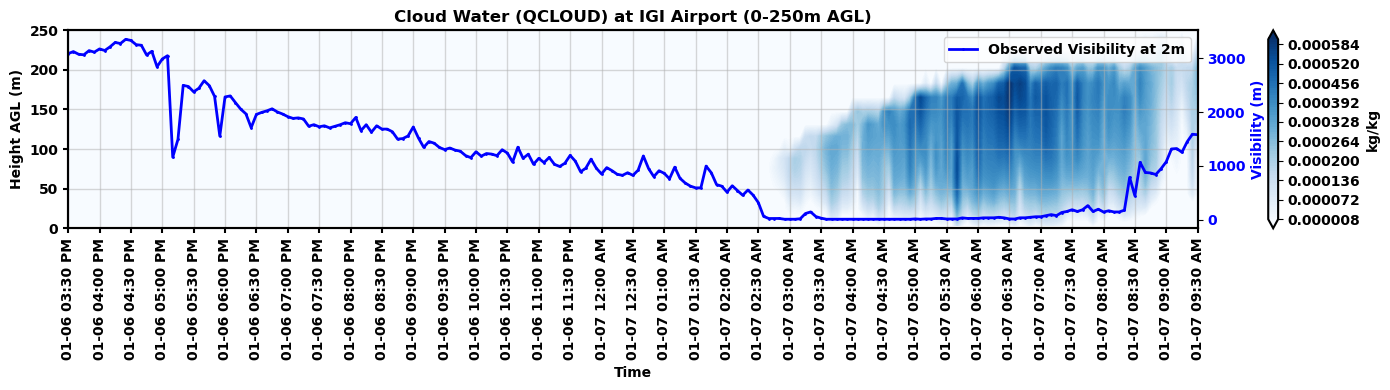

In [8]:
################################################################
# HOLLOMOVER PLOT FOR QCLOUD WITH OVERLAYED VISIBILITY DATA    #
# ______________________________________________________________#
################################################################
#__[Figure5b]__#

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import pytz # Import pytz for explicit timezone handling
from datetime import timedelta
import sys

# Set global matplotlib parameters for bolder fonts and lines
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['axes.linewidth'] = 1.5
plt.rcParams['grid.linewidth'] = 1.0
plt.rcParams['lines.linewidth'] = 2.0

# Constants
g = 9.81 # gravity (m/s²)
max_height = 250 # Limit to 250m AGL
y_interval = 50 # Set y-axis interval to 10m

# Target IGI Airport Coordinates
target_lat = 28.5658
target_lon = 77.1035

# Path to the WRF output file
wrf_file = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"

# Path to the Visibility Excel file
visibility_file = "/home/users/choudhury/WRF-POST_Processing/Materials/visibility_data_230106.xlsx"

# --- 1. Load WRF Data ---
try:
    ds = xr.open_dataset(wrf_file)
except FileNotFoundError:
    print(f"Error: WRF file not found at {wrf_file}")
    sys.exit(1)
except Exception as e:
    print(f"Error opening WRF dataset: {e}")
    sys.exit(1)

# Find nearest grid point
def find_nearest(lat, lon, lats, lons):
    """Finds the nearest grid point (y_idx, x_idx) to given latitude and longitude."""
    dist = (lats - lat)**2 + (lons - lon)**2
    return np.unravel_index(dist.argmin(), dist.shape)

y_idx, x_idx = find_nearest(target_lat, target_lon,
                            ds.XLAT[0].values,
                            ds.XLONG[0].values)

print(f"Nearest WRF grid point: ({y_idx}, {x_idx})")
print(f"Actual coordinates at WRF grid point: {ds.XLAT[0,y_idx,x_idx].values:.4f}°N, "
      f"{ds.XLONG[0,y_idx,x_idx].values:.4f}°E")

# WRF Time array (convert to IST and make timezone-aware)
try:
    # Convert XTIME to UTC first, then localize/convert to IST
    time_array_utc = pd.to_datetime([str(t) for t in ds.XTIME.values], utc=True)
    ist_timezone = pytz.timezone('Asia/Kolkata')
    time_array_ist = time_array_utc.tz_convert(ist_timezone)

except KeyError:
    print("Error: 'XTIME' variable not found in the WRF dataset. Check the variable name.")
    sys.exit(1)
except Exception as e:
    print(f"Error converting WRF time data: {e}")
    sys.exit(1)

# Height calculation (staggered -> unstaggered -> AGL)
PH = ds.PH[:, :, y_idx, x_idx]
PHB = ds.PHB[:, :, y_idx, x_idx]
HGT = ds.HGT[0, y_idx, x_idx]

Z_stag = (PH + PHB) / g
Z_unstag = 0.5 * (Z_stag[:,1:] + Z_stag[:,:-1])
Z_agl = Z_unstag - HGT

# Filter for 0–250 m AGL
height_mask = Z_agl[0].values <= max_height
z_agl_filtered = Z_agl[0].values[height_mask]

# Extract only QCLOUD for plotting
qcloud_array = ds.QCLOUD[:, :, y_idx, x_idx].values[:, height_mask].T

ds.close()

# --- 2. Load and Process Visibility Data ---
visibility_df = None
try:
    visibility_df = pd.read_excel(visibility_file)
    # Convert 'Timestamp' column to datetime objects
    # Format: YY/MM/DD HH:MM:SS (e.g., 23/01/06 00:02:00)
    visibility_df['Timestamp'] = pd.to_datetime(visibility_df['Timestamp'], format='%y/%m/%d %H:%M:%S')

    # Localize Excel timestamps to IST and make timezone-aware
    ist_timezone = pytz.timezone('Asia/Kolkata')
    visibility_df['Timestamp'] = visibility_df['Timestamp'].dt.tz_localize(ist_timezone)

    # Reindex visibility data to match WRF time steps (nearest neighbor)
    visibility_aligned = visibility_df.set_index('Timestamp').reindex(time_array_ist, method='nearest')
    visibility_values_aligned = visibility_aligned['Value'].values

    print(f"\nLoaded Visibility Data from: {visibility_file}")
    print(f"Visibility data points: {len(visibility_df)}")
    print(f"Visibility data aligned to WRF time steps: {len(visibility_values_aligned)}")

except FileNotFoundError:
    print(f"Error: Visibility file not found at {visibility_file}. Skipping visibility plot.")
    visibility_df = None
except KeyError:
    print("Error: 'Timestamp' or 'Value' column not found in visibility Excel. Skipping visibility plot.")
    visibility_df = None
except Exception as e:
    print(f"An error occurred while loading/processing visibility data: {e}. Skipping visibility plot.")
    visibility_df = None

# --- 3. Plotting Function (Corrected) ---
def plot_hovmoller_with_visibility(time, height, data, title, cmap, units,
                                   visibility_time, visibility_values,
                                   visibility_units="m", vmin=None, vmax=None):
    """
    Generates a Hovmöller diagram with an optional overlaid visibility line plot.
    """
    if data.size == 0:
        print(f"Warning: No primary data to plot for {title}. Skipping.")
        return

    fig, ax1 = plt.subplots(figsize=(15, 4))

    # --- Plot primary WRF data (contourf) ---
    cont = ax1.contourf(time, height, data, levels=100, cmap=cmap, extend='both', vmin=vmin, vmax=vmax)
    cbar = fig.colorbar(cont, ax=ax1)
    cbar.set_label(units, weight='bold')

    ax1.set_xlabel("Time", weight='bold')
    ax1.set_ylabel("Height AGL (m)", weight='bold')
    ax1.set_title(f"{title} at IGI Airport (0-{max_height}m AGL)", weight='bold')

   # Correct way to handle x-axis ticks and labels:
    ax1.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # 30-min intervals
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %I:%M %p", tz=ist_timezone))  # IST-aware formatting

    ax1.tick_params(axis='x', labelrotation=90, labelsize=10, width=1.5) # Apply rotation and other params

    ax1.set_ylim(0, max_height)
    ax1.set_yticks(np.arange(0, max_height + y_interval, y_interval))
    ax1.grid(alpha=0.5, linewidth=1.0)
    ax1.tick_params(axis='y', labelsize=10, width=1.5)


    # --- Overlay Visibility Data on a secondary Y-axis ---
    if visibility_values is not None and len(visibility_values) > 0:
        ax2 = ax1.twinx() # Create a second y-axis that shares the same x-axis
        ax2.plot(visibility_time, visibility_values,
                 color='blue', linestyle='-', marker='o', markersize=1, label='Observed Visibility at 2m')
        ax2.set_ylabel(f"Visibility ({visibility_units})", color='blue', weight='bold')
        ax2.tick_params(axis='y', labelcolor='blue')
        ax2.legend(loc='upper right', fontsize=10)

    fig.tight_layout() # Adjust plot to prevent labels from overlapping
    plt.show()

# --- Generate Plot for QCLOUD ---
plot_hovmoller_with_visibility(
    time_array_ist,
    z_agl_filtered,
    qcloud_array,
    "Cloud Water (QCLOUD)",
    "Blues",
    "kg/kg",
    time_array_ist,
    visibility_values_aligned if visibility_df is not None else None,
    vmin=1e-6,
    vmax=np.nanmax(qcloud_array)  # Optional: set vmax to max QCLOUD value
)


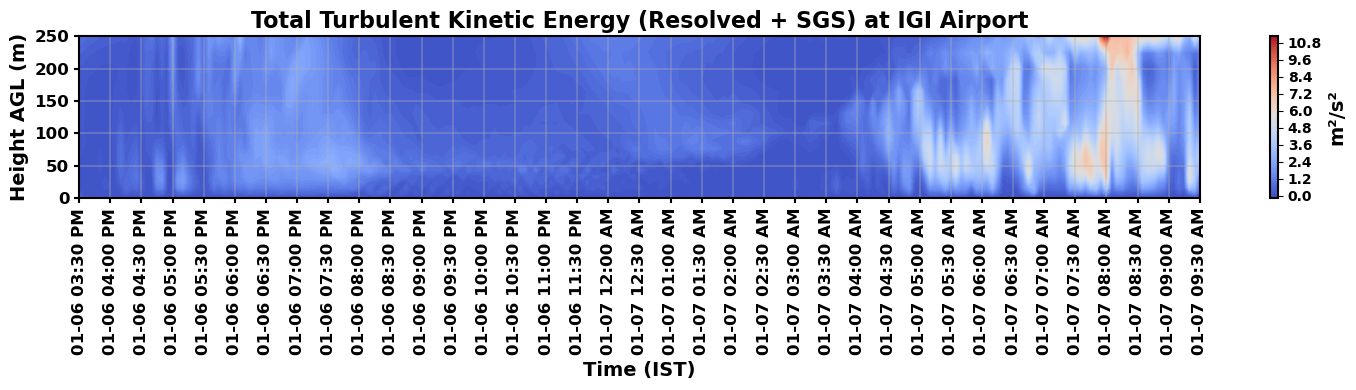

In [9]:
################################################################
# HOLLOMOVER PLOT FOR Total TKE                                #
# _____________________________________________________________#
################################################################
#__[Figure8c]__#

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# === USER SETTINGS ===
max_height = 250  # Change this to adjust height limit (in meters)
y_interval = 50   # Y-axis tick interval
target_lat = 28.5658
target_lon = 77.1035
wrf_file = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"

# === LOAD DATASET ===
ds = xr.open_dataset(wrf_file)

def find_nearest(lat, lon, lats, lons):
    dist = (lats - lat)**2 + (lons - lon)**2
    return np.unravel_index(dist.argmin(), dist.shape)

y_idx, x_idx = find_nearest(target_lat, target_lon,
                            ds.XLAT[0].values,
                            ds.XLONG[0].values)

time_array_ist = pd.to_datetime([str(t) for t in ds.XTIME.values]) + pd.Timedelta(hours=5, minutes=30)

# === HEIGHT CALCULATION ===
g = 9.81
PH = ds.PH[:, :, y_idx, x_idx]
PHB = ds.PHB[:, :, y_idx, x_idx]
HGT = ds.HGT[0, y_idx, x_idx]
Z_stag = (PH + PHB) / g
Z_unstag = 0.5 * (Z_stag[:,1:] + Z_stag[:,:-1])
Z_agl = Z_unstag - HGT
height_mask = Z_agl[0].values <= max_height
z_agl_filtered = Z_agl[0].values[height_mask]

# === EXTRACT SGS TKE ===
m11 = ds.m11[:, :, y_idx, x_idx].values[:, height_mask].T
m22 = ds.m22[:, :, y_idx, x_idx].values[:, height_mask].T
m33 = ds.m33[:, :, y_idx, x_idx].values[:, height_mask].T
tke_sgs = 0.5 * (m11 + m22 + m33)

# === UNSTAGGER VELOCITIES AND COMPUTE PERTURBATIONS ===
def unstagger(var, axis):
    return 0.5 * (var[:, :, :-1] + var[:, :, 1:]) if axis == -1 else None

U = unstagger(ds.U[:, :, y_idx, :], -1)[:, :, x_idx].values[:, height_mask].T
V = unstagger(ds.V[:, :, :, x_idx], -1)[:, :, y_idx].values[:, height_mask].T
W = 0.5 * (ds.W[:, 1:, y_idx, x_idx].values + ds.W[:, :-1, y_idx, x_idx].values)
W = W[:, height_mask].T

def perturb(arr): return arr - np.mean(arr, axis=1, keepdims=True)

resolved_tke = 0.5 * (perturb(U)**2 + perturb(V)**2 + perturb(W)**2)

# === TOTAL TKE ===
total_tke = resolved_tke + tke_sgs

# === PLOTTING ===
def plot_hovmoller(time, height, data, title, cmap, units):
    plt.figure(figsize=(15, 4))
    cont = plt.contourf(time, height, data, levels=100, cmap=cmap)
    cbar = plt.colorbar(cont)
    cbar.set_label(units, fontsize=14, fontweight='bold')
    plt.xlabel("Time (IST)", fontsize=14, fontweight='bold')
    plt.ylabel("Height AGL (m)", fontsize=14, fontweight='bold')
    plt.title(title, fontsize=16, fontweight='bold')
    plt.xticks(rotation=90, fontsize=12, fontweight='bold')
    plt.yticks(np.arange(0, max_height + y_interval, y_interval), fontsize=12, fontweight='bold')
    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %I:%M %p"))
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
    plt.grid(alpha=0.4, linewidth=1.2)
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)
    plt.ylim(0, max_height)
    plt.tight_layout()
    plt.show()

plot_hovmoller(time_array_ist, z_agl_filtered, total_tke,
               "Total Turbulent Kinetic Energy (Resolved + SGS) at IGI Airport", "coolwarm", "m²/s²")

ds.close()


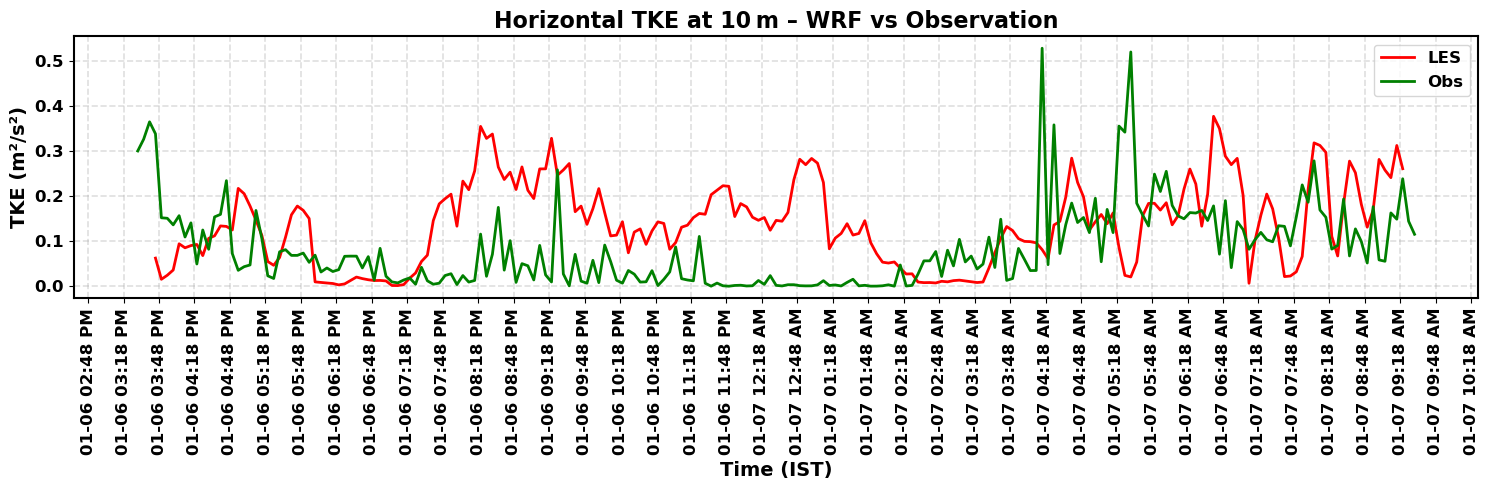

📊 TKE Bias Statistics (WRF vs Observation):
-------------------------------------------
Mean Bias Error (MBE):      0.0585 m²/s²
Root Mean Square Error:     0.1362 m²/s²
Mean Absolute Error (MAE):  0.1064 m²/s²
Pearson Correlation (r):    0.0545


In [10]:
################################################################
# Horizontal TKE at 10m - WRF vs Observation                   #
# _____________________________________________________________#
################################################################
#__[Figure5c]__#


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import pearsonr
import numpy as np

# === 1. Load observational data ===
obs_10m_path = "/home/users/choudhury/WRF-POST_Processing/Materials/06-01-2023.csv"
df_obs = pd.read_csv(obs_10m_path)
df_obs.columns = df_obs.columns.str.strip()

# Parse timestamps and drop bad rows
df_obs['Timestamps'] = pd.to_datetime(df_obs['Timestamps'], format="%d-%m-%Y %H:%M", errors='coerce')
df_obs.dropna(subset=['Timestamps'], inplace=True)

# Rename and make Time column timezone-naive
df_obs.rename(columns={'Timestamps': 'Time'}, inplace=True)
df_obs['Time'] = df_obs['Time'].dt.tz_localize(None)  # Fix for merge

# === 2. Compute observed TKE from u,v std dev ===
df_obs['TKE_10m_uv'] = 0.5 * (df_obs['st_dev(u)']**2 + df_obs['st_dev(v)']**2)

# === 3. Extract WRF data ===
u10 = ds.U10[:, y_idx, x_idx].values
v10 = ds.V10[:, y_idx, x_idx].values
times = pd.to_datetime(time_array_ist)

df_wrf = pd.DataFrame({
    "Time": times,
    "U10": u10,
    "V10": v10
})

# Compute rolling standard deviation (30-min window with 5-min data = 6 points)
df_wrf['std_u'] = df_wrf['U10'].rolling(window=6, center=True).std()
df_wrf['std_v'] = df_wrf['V10'].rolling(window=6, center=True).std()
df_wrf['WRF_TKE_10m'] = 0.5 * (df_wrf['std_u']**2 + df_wrf['std_v']**2)

# Remove timezone from both Time columns to make them naive
df_obs['Time'] = df_obs['Time'].dt.tz_localize(None)
df_wrf['Time'] = df_wrf['Time'].dt.tz_localize(None)

# Merge on time
df_merged = pd.merge(
    df_wrf[['Time', 'WRF_TKE_10m']],
    df_obs[['Time', 'TKE_10m_uv']],
    on='Time',
    how='inner'
)


# === 5. Plot ===
fig, ax = plt.subplots(figsize=(15, 5))

ax.plot(df_merged['Time'], df_merged['WRF_TKE_10m'], label="LES", color='red', linewidth=2)
ax.plot(df_merged['Time'], df_merged['TKE_10m_uv'], label="Obs", color='green', linewidth=2)

ax.set_title("Horizontal TKE at 10 m – WRF vs Observation", fontsize=16, fontweight='bold')
ax.set_xlabel("Time (IST)", fontsize=14, fontweight='bold')
ax.set_ylabel("TKE (m²/s²)", fontsize=14, fontweight='bold')

# 12-hour format with AM/PM
ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %I:%M %p"))

plt.xticks(rotation=90, fontsize=12, fontweight='bold')
plt.yticks(fontsize=12, fontweight='bold')
ax.grid(alpha=0.4, linestyle='--', linewidth=1.2)
ax.legend(fontsize=12)

plt.tight_layout()
plt.show()

# === 6. Bias Statistics ===
df_clean = df_merged.dropna(subset=['WRF_TKE_10m', 'TKE_10m_uv'])
model_tke = df_clean['WRF_TKE_10m'].values
obs_tke = df_clean['TKE_10m_uv'].values

mbe = np.mean(model_tke - obs_tke)
rmse = np.sqrt(mean_squared_error(obs_tke, model_tke))
mae = mean_absolute_error(obs_tke, model_tke)
r_value, _ = pearsonr(obs_tke, model_tke)

# === 7. Print Bias Metrics ===
print(f"📊 TKE Bias Statistics (WRF vs Observation):")
print(f"-------------------------------------------")
print(f"Mean Bias Error (MBE):      {mbe:.4f} m²/s²")
print(f"Root Mean Square Error:     {rmse:.4f} m²/s²")
print(f"Mean Absolute Error (MAE):  {mae:.4f} m²/s²")
print(f"Pearson Correlation (r):    {r_value:.4f}")


Nearest grid point: (251, 320)


/tmp/ipykernel_3980586/1091717739.py:65: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for t in range(ds.dims["Time"]):


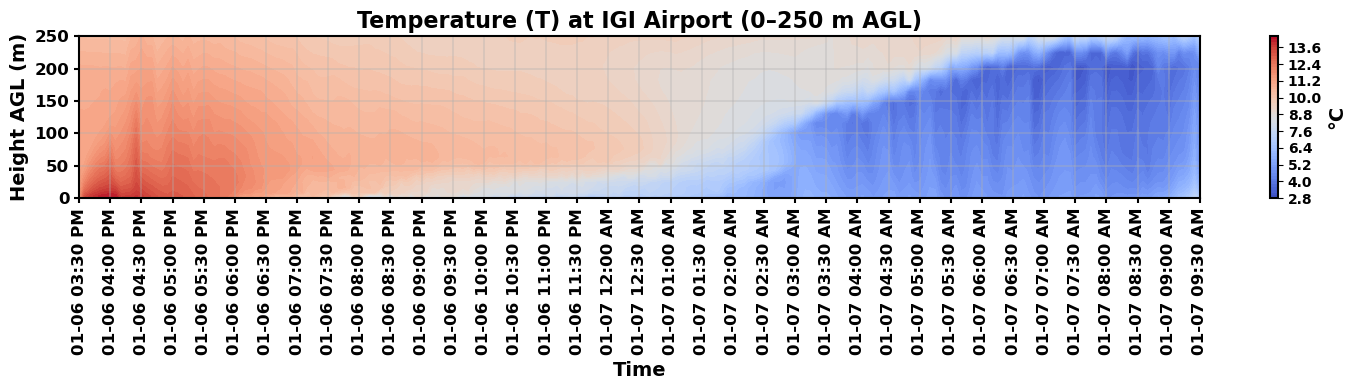

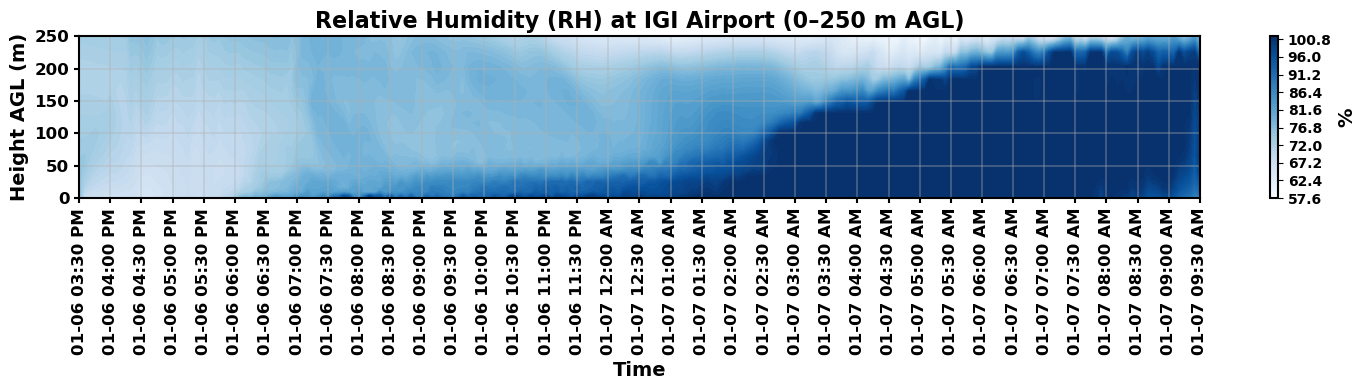

In [11]:
#########################################################
#HOLLOMOVER PLOT FOR TEMPERATURE AND RELATIVE HUMIDITY ##
#_______________________________________________________#
#########################################################
#__[Figure8a and 8b]__# 


import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd

# Constants
g = 9.81  # Gravity (m/s²)
Rd = 287.05  # Gas constant for dry air (J/kg/K)
Rv = 461.5  # Gas constant for water vapor (J/kg/K)
Cp = 1004  # Specific heat capacity of dry air (J/kg/K)
max_height = 250  # Limit to 250m AGL
y_interval = 50  # Set y-axis interval to 10m

# Target IGI Airport Coordinates
target_lat = 28.5853
target_lon = 77.22072

# WRF output file
wrf_file = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"

# Open dataset
try:
    ds = xr.open_dataset(wrf_file)
except FileNotFoundError:
    print(f"Error: File not found at {wrf_file}")
    exit()
except Exception as e:
    print(f"Error opening dataset: {e}")
    exit()

# Find nearest grid point
def find_nearest(lat, lon, lats, lons):
    dist = (lats - lat)**2 + (lons - lon)**2
    return np.unravel_index(dist.argmin(), dist.shape)

y_idx, x_idx = find_nearest(target_lat, target_lon,
                            ds.XLAT[0].values,
                            ds.XLONG[0].values)
print(f"Nearest grid point: ({y_idx}, {x_idx})")

# Data storage
times = pd.to_datetime([str(t) for t in ds.XTIME.values]) + pd.Timedelta(hours=5, minutes=30)
temp_data = []
rh_data = []

# Height calculation (staggered -> unstaggered -> AGL)
PH = ds.PH[:, :, y_idx, x_idx]
PHB = ds.PHB[:, :, y_idx, x_idx]
HGT = ds.HGT[0, y_idx, x_idx]

Z_stag = (PH + PHB) / g
Z_unstag = 0.5 * (Z_stag[:, 1:] + Z_stag[:, :-1])  # unstaggered
Z_agl = Z_unstag - HGT
z_agl_levels = Z_agl[0].values  # Save height levels (time-invariant)

# Extract temperature and RH for each timestep
for t in range(ds.dims["Time"]):
    THETA = ds.T[t, :, y_idx, x_idx]
    P = ds.P[t, :, y_idx, x_idx] + ds.PB[t, :, y_idx, x_idx]
    T = THETA + 300  # potential temperature to T
    TEMP = T * (P / 100000) ** (Rd / Cp)
    TEMP_C = TEMP - 273.15
    temp_data.append(TEMP_C.values)
    
    QVAPOR = ds.QVAPOR[t, :, y_idx, x_idx]
    T_C = TEMP - 273.15
    ES = 6.112 * np.exp((17.67 * T_C) / (T_C + 243.5))  # hPa
    QSAT = 0.622 * (ES / (P / 100))  # kg/kg
    RH = (QVAPOR / QSAT) * 100
    rh_data.append(RH.values)

ds.close()

# Convert to arrays
temp_array = np.array(temp_data).T  # shape: (height, time)
rh_array = np.array(rh_data).T

# Filter for 0-250m AGL
height_mask = z_agl_levels <= max_height
z_agl_filtered = z_agl_levels[height_mask]

def plot_hovmoller(time, height, data, title, cmap, units):
    plt.figure(figsize=(15, 4))
    cont = plt.contourf(time, height, data, levels=70, cmap=cmap)
    cbar = plt.colorbar(cont)
    cbar.set_label(units, fontsize=14, fontweight='bold')

    # Optional: Draw contour lines (without labels)
    #plt.contour(time, height, data, levels=10, colors='k', linewidths=1.0)

    plt.xlabel("Time", fontsize=14, fontweight='bold')
    plt.ylabel("Height AGL (m)", fontsize=14, fontweight='bold')
    plt.title(f"{title} at IGI Airport (0–250 m AGL)", fontsize=16, fontweight='bold')

    plt.xticks(rotation=90, fontsize=12, fontweight='bold')
    plt.yticks(np.arange(0, max_height + y_interval, y_interval), fontsize=12, fontweight='bold')

    ax = plt.gca()
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %I:%M %p"))  # 12-hour format
    ax.xaxis.set_major_locator(mdates.MinuteLocator(interval=30))  # 30-min intervals

    plt.ylim(0, max_height)
    plt.grid(alpha=0.4, linewidth=1.2)
    ax.tick_params(axis='both', which='major', labelsize=12, width=1.5)

    plt.tight_layout()
    plt.show()


# Generate plots
plot_hovmoller(times, z_agl_filtered, temp_array[height_mask, :],
                "Temperature (T)", "coolwarm", "°C")
plot_hovmoller(times, z_agl_filtered, rh_array[height_mask, :],
                "Relative Humidity (RH)", "Blues", "%")


In [ ]:
#####################################################
# Temperature inversion profile (Gradient of theta) #
# For 7th Jan 2023 (01:00–03:30 AM IST)             #
#___________________________________________________#
#####################################################
#__[Figure7a]__#


import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ✅ Load WRF file
wrf_file = "/home/users/choudhury/WRF/v4.6_1/OUTPUT/Morrison_7th_Jan_2023/wrfout_d03_combined.nc"
ds = xr.open_dataset(wrf_file)

# ✅ Compute geopotential height (Z)
g = 9.81
Z_stag = (ds["PH"] + ds["PHB"]) / g

# ✅ Unstagger the vertical levels
Z_unstaggered = 0.5 * (Z_stag.isel(bottom_top_stag=slice(1, None)) +
                       Z_stag.isel(bottom_top_stag=slice(0, -1)))
Z_unstaggered = Z_unstaggered.rename({"bottom_top_stag": "bottom_top"})

# ✅ Height above ground level (AGL)
HGT_expanded, _ = xr.broadcast(ds["HGT"], Z_unstaggered)
Z_agl = Z_unstaggered - HGT_expanded

# ✅ Potential temperature (theta)
theta = ds["T"] + 300

# ✅ Mean over horizontal dimensions
theta_mean = theta.mean(dim=["west_east", "south_north"])
Z_mean = Z_agl.mean(dim=["west_east", "south_north"])

# ✅ Compute vertical gradient of theta (dθ/dz)
dtheta_dz = theta_mean.differentiate("bottom_top") / Z_mean.differentiate("bottom_top")

# ✅ Decode WRF Times properly
time_strings = [''.join(t.astype(str)).strip() for t in ds["Times"].values]
time_series = pd.to_datetime(time_strings, format="%Y-%m-%d_%H:%M:%S")

# ✅ Define IST times and convert to UTC
target_times_ist = [
    "2023-01-07 01:00:00",
    "2023-01-07 01:30:00",
    "2023-01-07 02:00:00",
    "2023-01-07 02:30:00",
    "2023-01-07 03:00:00",
    "2023-01-07 03:30:00"
]
target_times_utc = pd.to_datetime(target_times_ist) - pd.Timedelta(hours=5, minutes=30)

# ✅ Match each UTC time to nearest available time index
selected_indices = [np.argmin(np.abs(time_series - t)) for t in target_times_utc]

# ✅ Filter duplicate indices
unique_indices, unique_labels = [], []
for idx, label in zip(selected_indices, target_times_ist):
    if idx not in unique_indices:
        unique_indices.append(idx)
        unique_labels.append(label)

# ✅ Debug: Show matched times
print("Requested IST times and matched WRF UTC times:")
for ist, idx in zip(unique_labels, unique_indices):
    print(f"{ist} IST → Index: {idx}, UTC: {time_series[idx]}")

# ✅ Plotting
fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.plasma(np.linspace(0, 1, len(unique_indices)))

# Plot each time step
for i, idx in enumerate(unique_indices):
    ax.plot(
        dtheta_dz.isel(Time=idx),
        Z_mean.isel(Time=idx),
        label=unique_labels[i],  # Label as IST
        color=colors[i],
        linewidth=2
    )

# Reference vertical line at dθ/dz = 0
ax.axvline(0, linestyle='--', color='k', linewidth=1.5)

# === Labels and Title ===
ax.set_xlabel("dθ/dz (K/m)", fontsize=14, fontweight="bold")
ax.set_ylabel("Height AGL (m)", fontsize=14, fontweight="bold")
ax.set_title("Potential Temperature Gradient Profiles\n(7th Jan 2023, 01:00–03:30 AM IST)",
             fontsize=15, fontweight="bold")

# === Axis Settings ===
ax.set_ylim(0, 200)
ax.tick_params(axis='both', labelsize=12, width=1.5, labelcolor='black')
for label in ax.get_xticklabels() + ax.get_yticklabels():
    label.set_fontweight('bold')

# === Legend (Inside Plot, Top-Right Corner) ===
legend = ax.legend(
    title="Time (IST)",
    fontsize=9,
    title_fontsize=10,
    loc="upper right",           # Move legend inside top-right
    frameon=True,
    framealpha=0.9,
    borderpad=0.5,
    handlelength=1.2
)
legend.get_frame().set_edgecolor('gray')
legend.get_frame().set_linewidth(1.2)
for text in legend.get_texts():
    text.set_fontweight('bold')
legend.get_title().set_fontweight('bold')

# === Grid ===
ax.grid(linewidth=1.2, alpha=0.5)

plt.tight_layout()
plt.show()
